# Prueba Grupo Hotusa

##### 1.Representa gráficamente el número de cancelaciones y reservas confirmadas para cada fecha de check in (date_checkin).
##### 2.Número de reservas confirmadas y cancelaciones para cada agencia (agengy_id). Selecciona únicamente el top 10 en cuanto a volumen total de reservas.
##### 3.Evolución del precio mínimo, precio medio, precio máximo y revenue para cada fecha de check in (date_checkin) (preferiblemente representadas en la misma gráfica superpuestas, revenue puede ir según la escala) (Nótese: revenue = mean_price_per_night * nights) Se puede extraer alguna conclusión al comparar la evolución entre los precios y el revenue. ¿Hay fechas mal vendidas?
##### 4.Las reservas entran con una antelación. La antelación se calcula como: date_checkin - date_gen. El objetivo de esta pregunta es observar como afecta la antelación a la cancelación y confirmación de las reservas. ¿Cuándo suelen entrar las reservas? ¿el ratio de cancelación es constante para diferentes antelaciones? (Si es posible agrupa las antelaciones en intervalos: [0,3),[3,7),[7,30),[30,90),[90,120] días)
##### 5.Elabora 2 análisis por tu parte: Algunas sugerencias: Diferencias entre precio de venta de reservas canceladas y confirmadas, cómo afecta el número de noches al precio medio de la reserva, ratio de cancelación por origen (origen_id), evolución del precio de venta por mes, qué considerarías outliers...

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = "hotusa_analysis.csv"

# Lee el archivo CSV directamente en un DataFrame llamado "df"
df = pd.read_csv(file_path)

# Imprime el DataFrame
df.head(5)


,Unnamed: 0,res_id,date_gen,date_checkin,nights,guests,ori_id,agency_id,mean_price_per_night,status
0,1,12423041,2021-12-17,2022-01-07,2,2,12,Agencia_61,52.50,Cancelled
1,2,12423225,2021-12-17,2022-01-07,2,2,12,Agencia_61,52.50,Cancelled
2,3,12423227,2021-12-17,2022-01-09,1,1,12,Agencia_61,50.10,Cancelled
3,4,12912535,2022-02-18,2022-02-19,1,2,4,Agencia_52,0.00,Confirmed
4,5,10194056,2020-09-16,2021-01-20,4,3,4,Agencia_10,60.69,Confirmed


### 1.Representa gráficamente el número de cancelaciones y reservas confirmadas para cada fecha de check in (date_checkin).

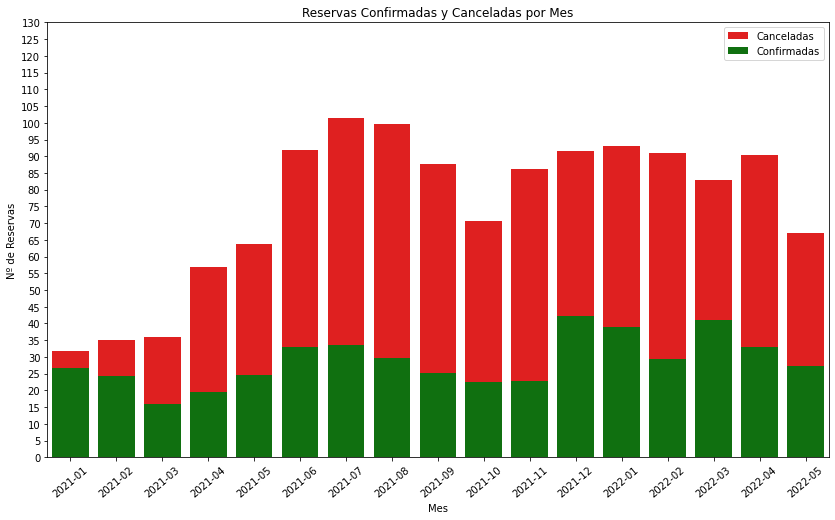

In [3]:
# Filtrar solo las reservas confirmadas y canceladas
reservas_confirmadas = df[df['status'] == 'Confirmed']
reservas_canceladas = df[df['status'] == 'Cancelled']

# Agrupar por fecha de check-in y contar el número de reservas confirmadas y canceladas
confirmadas_por_fecha = reservas_confirmadas.groupby('date_checkin').size().reset_index(name='confirmadas')
canceladas_por_fecha = reservas_canceladas.groupby('date_checkin').size().reset_index(name='canceladas')

# Combinar los datos en un solo DataFrame
datos_por_fecha = pd.merge(confirmadas_por_fecha, canceladas_por_fecha, on='date_checkin', how='outer').fillna(0)

# Ordenar por fecha de check-in
datos_por_fecha = datos_por_fecha.sort_values(by='date_checkin')

# Agregar una columna para el mes
datos_por_fecha['date_checkin'] = pd.to_datetime(datos_por_fecha['date_checkin'])
datos_por_fecha['month'] = datos_por_fecha['date_checkin'].dt.to_period('M')

# Crear el gráfico
plt.figure(figsize=(14, 8))
sns.barplot(x='month', y='canceladas', data=datos_por_fecha, color='red', label='Canceladas', errwidth=0)
sns.barplot(x='month', y='confirmadas', data=datos_por_fecha, color='green', label='Confirmadas', errwidth=0)
plt.xticks(rotation=40)
plt.xlabel('Mes')
plt.yticks(range(0, int(datos_por_fecha[['canceladas', 'confirmadas']].max().max()) - 60, 5))
plt.ylabel('Nº de Reservas')
plt.title('Reservas Confirmadas y Canceladas por Mes')
plt.legend()
plt.show()

##### En esta gráfica 

### 2.Número de reservas confirmadas y cancelaciones para cada agencia (agengy_id). Selecciona únicamente el top 10 en cuanto a volumen total de reservas.

In [20]:
# Agrupar por agencia y estado de la reserva, y contar el número de reservas
reservas_por_agencia = df.groupby(['agency_id', 'status']).size().reset_index(name='count')

# Filtrar solo las reservas confirmadas y canceladas
reservas_confirmadas = reservas_por_agencia[reservas_por_agencia['status'] == 'Confirmed']
reservas_canceladas = reservas_por_agencia[reservas_por_agencia['status'] == 'Cancelled']

# Sumar el número total de reservas (confirmadas y canceladas) por agencia
total_reservas_por_agencia = pd.merge(reservas_confirmadas, reservas_canceladas, on='agency_id', suffixes=('_confirm', '_cancel'))

# Calcular el total de reservas por agencia
total_reservas_por_agencia['total_reservas'] = total_reservas_por_agencia['count_confirmadas'] + total_reservas_por_agencia['count_canceladas']

# Seleccionar el top 10 en términos de volumen total de reservas
top_10_agencias = total_reservas_por_agencia.sort_values(by='total_reservas', ascending=False).head(10)
top_10_agencias = top_10_agencias.drop(['status_confirmadas', 'status_canceladas'], axis=1)

# Mostrar el resultado
top_10_agencias

,agency_id,count_confirmadas,count_canceladas,total_reservas
0,Agencia_1,9633,17010,26643
8,Agencia_2,1888,8710,10598
14,Agencia_4,547,4568,5115
17,Agencia_5,637,2439,3076
20,Agencia_6,858,1966,2824
3,Agencia_12,490,1535,2025
11,Agencia_3,361,1030,1391
23,Agencia_8,126,502,628
22,Agencia_7,36,241,277
1,Agencia_10,122,95,217


#### Las  

### 3.Evolución del precio mínimo, precio medio, precio máximo y revenue para cada fecha de check in (date_checkin) (preferiblemente representadas en la misma gráfica superpuestas, revenue puede ir según la escala) (Nótese: revenue = mean_price_per_night * nights)

In [6]:
# Calcular la columna 'revenue'
df['revenue'] = df['mean_price_per_night'] * df['nights']

# Crear el DataFrame preciototal_con_reserva
preciototal_con_reserva = df[['date_checkin', 'revenue']].copy()

# Calcular el máximo y mínimo de revenue por 'date_checkin'
preciototal_con_reserva['precio_max'] = df.groupby('date_checkin')['revenue'].transform('max')
preciototal_con_reserva['precio_min'] = df.groupby('date_checkin')['revenue'].transform('min')

# Mostrar las primeras 10 filas del resultado
preciototal_con_reserva.head(10)


,date_checkin,revenue,precio_max,precio_min
0,2022-01-07,105.00,729.73,29.99
1,2022-01-07,105.00,729.73,29.99
2,2022-01-09,50.10,1125.19,22.50
3,2022-02-19,0.00,1145.88,0.00
4,2021-01-20,242.76,475.15,24.82
5,2021-02-26,214.20,243.95,0.00
6,2021-02-26,214.20,243.95,0.00
7,2021-02-26,124.41,243.95,0.00
8,2021-02-26,214.20,243.95,0.00
9,2021-02-26,214.20,243.95,0.00


In [7]:
# Calcular la columna 'revenue'
df['revenue'] = df['mean_price_per_night'] * df['nights']

# Crear el DataFrame preciototal_con_reserva
preciototal_con_reserva = df[['date_checkin', 'revenue']].copy()

# Calcular el máximo y mínimo de revenue por 'date_checkin'
preciototal_con_reserva['precio_max'] = df.groupby('date_checkin')['revenue'].transform('max')
preciototal_con_reserva['precio_min'] = df.groupby('date_checkin')['revenue'].transform('min')
preciototal_con_reserva['precio_medio'] = df['mean_price_per_night']

# Calcular la suma de revenue por 'date_checkin'
sum_revenue_by_date = df.groupby('date_checkin')['revenue'].sum().reset_index(name='sum_revenue')
#print(sum_revenue_by_date)

# Fusionar los resultados con preciototal_con_reserva
preciototal_con_reserva = pd.merge(preciototal_con_reserva, sum_revenue_by_date, on='date_checkin', how='left')
preciototal_con_reserva = preciototal_con_reserva.sort_values(by='date_checkin')
preciototal_con_reserva = preciototal_con_reserva.drop_duplicates(subset='date_checkin', keep='first')
preciototal_con_reserva = preciototal_con_reserva.drop('revenue', axis=1)

# Mostrar las primeras 10 filas del resultado
print(preciototal_con_reserva.head(5))


     date_checkin  precio_max  precio_min  precio_medio  sum_revenue
1692   2021-01-01      600.87       33.26         33.28      8355.33
1911   2021-01-02      264.00        0.00         48.56      7361.92
1407   2021-01-03      453.09        0.00         58.50      4749.34
1664   2021-01-04      311.92        0.00         44.10      3393.98
1571   2021-01-05       89.22       17.10         35.10      2072.79


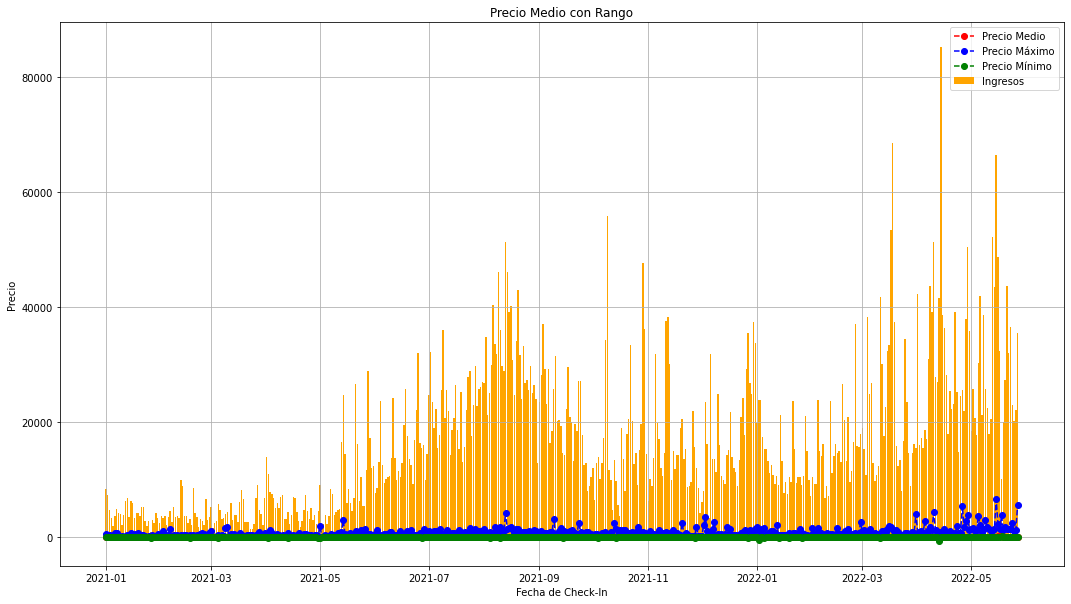

In [11]:
preciototal_con_reserva['date_checkin'] = pd.to_datetime(preciototal_con_reserva['date_checkin'])
preciototal_con_reserva['month'] = preciototal_con_reserva['date_checkin'].dt.to_period('M')

preciototal_con_reserva['date_checkin'] = pd.to_datetime(preciototal_con_reserva['date_checkin'])
preciototal_con_reserva = preciototal_con_reserva.sort_values(by='date_checkin')

plt.figure(figsize=(18, 10))
plt.plot(preciototal_con_reserva['date_checkin'], preciototal_con_reserva['precio_medio'], marker='o', linestyle='--', color='red', label='Precio Medio')
plt.plot(preciototal_con_reserva['date_checkin'], preciototal_con_reserva['precio_max'], marker='o', linestyle='--', color='blue', label='Precio Máximo')
plt.plot(preciototal_con_reserva['date_checkin'], preciototal_con_reserva['precio_min'], marker='o', linestyle='--', color='green', label='Precio Mínimo')

plt.bar(preciototal_con_reserva['date_checkin'], preciototal_con_reserva['sum_revenue'], color='orange', label='Ingresos')

plt.xlabel('Fecha de Check-In')
plt.ylabel('Precio')
plt.title('Precio Medio con Rango')
plt.legend()
plt.grid(True)
plt.show()

### Las reservas entran con una antelación. La antelación se calcula como: date_checkin - date_gen. El objetivo de esta pregunta es observar como afecta la antelación a la cancelación y confirmación de las reservas. ¿Cuándo suelen entrar las reservas? ¿el ratio de cancelación es constante para diferentes antelaciones? (Si es posible agrupa las antelaciones en intervalos: [0,3),[3,7),[7,30),[30,90),[90,120] días)

In [161]:
# Convertir las columnas 'date_gen' y 'date_checkin' a datetime
df['date_gen'] = pd.to_datetime(df['date_gen'])
df['date_checkin'] = pd.to_datetime(df['date_checkin'])

# Calcular la antelación
df['anticipation'] = (df['date_checkin'] - df['date_gen']).dt.days

# Crear intervalos de antelación
bins = [0, 3, 7, 30, 90, 120]
labels = ['[0,3)', '[3,7)', '[7,30)', '[30,90)', '[90,120]']
df['anticipation_interval'] = pd.cut(df['anticipation'], bins=bins, labels=labels, right=False)

# Calcular el número de reservas y cancelaciones por intervalo de antelación
counts = df.groupby('anticipation_interval')['status'].value_counts().unstack().fillna(0)

# Calcular el ratio de cancelación
counts['Cancellation_ratio_%'] = (counts['Cancelled'] / (counts['Cancelled'] + counts['Confirmed'])) * 100

# Mostrar los resultados
print("Anticipación y Ratio de Cancelación:")
print(counts[['Cancelled', 'Confirmed', 'Cancellation_ratio_%']])


Anticipación y Ratio de Cancelación:
status                 Cancelled  Confirmed  Cancellation_ratio_%
anticipation_interval                                            
[0,3)                      16071       2212             87.901329
[3,7)                       7377       1920             79.348177
[7,30)                     10398       5177             66.760835
[30,90)                     3798       3426             52.574751
[90,120]                     376        548             40.692641


### Elabora 2 análisis por tu parte:
### Algunas sugerencias: Diferencias entre precio de venta de reservas canceladas y confirmadas, cómo afecta el número de noches al precio medio de la reserva, ratio de cancelación por origen (origen_id), evolución del precio de venta por mes, qué considerarías outliers...

In [168]:
# Crear intervalos de noches reservadas
night_bins = [1, 3, 6, 10, 100]
night_labels = ['[1,3)', '[3,6)', '[6,10)', '10 o +']

df['night_interval'] = pd.cut(df['nights'], bins=night_bins, labels=night_labels, right=False)

# Calcular el número de reservas y cancelaciones por origen y por intervalo de noches reservadas
counts = df.groupby(['ori_id', 'night_interval', 'status']).size().unstack(fill_value=0)

# Calcular el ratio de cancelación
counts['cancellation_ratio'] = (counts['Cancelled'] / (counts['Cancelled'] + counts['Confirmed'])) * 100

# Mostrar los resultados
print("Ratio de Cancelación por Origen y Noches Reservadas:")
print(counts[['Cancelled', 'Confirmed', 'cancellation_ratio']])


Ratio de Cancelación por Origen y Noches Reservadas:
status                 Cancelled  Confirmed  cancellation_ratio
ori_id night_interval                                          
4      [1,3)                3336        461           87.858836
       [3,6)                 616        173           78.073511
       [6,10)                 71         22           76.344086
       10 o +                 27          5           84.375000
7      [1,3)                   4          0          100.000000
       [3,6)                   2          0          100.000000
       [6,10)                  2          0          100.000000
       10 o +                  1          0          100.000000
9      [1,3)                 138         73           65.402844
       [3,6)                 210         53           79.847909
       [6,10)                 41          7           85.416667
       10 o +                  1          4           20.000000
10     [1,3)                 639          7        

In [169]:
# Ordenar el DataFrame por el ratio de cancelación en orden descendente
top_cancelation_ratio = counts.sort_values(by='cancellation_ratio', ascending=False)

# Seleccionar las primeras 10 filas (los 10 principales)
top_10_cancelation_ratio = top_cancelation_ratio.head(10)

# Mostrar el resumen
print("Top 10 por Ratio de Cancelación:")
print(top_10_cancelation_ratio[['Cancelled', 'Confirmed', 'cancellation_ratio']])

Top 10 por Ratio de Cancelación:
status                 Cancelled  Confirmed  cancellation_ratio
ori_id night_interval                                          
10     10 o +                  5          0          100.000000
       [6,10)                  8          0          100.000000
7      [1,3)                   4          0          100.000000
       [3,6)                   2          0          100.000000
       [6,10)                  2          0          100.000000
       10 o +                  1          0          100.000000
10     [1,3)                 639          7           98.916409
       [3,6)                  50          4           92.592593
4      [1,3)                3336        461           87.858836
12     [1,3)                 222         32           87.401575


In [181]:
# Convertir las columnas 'date_checkin' a datetime
df['date_checkin'] = pd.to_datetime(df['date_checkin'])

# Filtrar las reservas dentro de la época de temporada alta
seasonal_df = df[(df['date_checkin'].dt.month >= 4) & (df['date_checkin'].dt.month <= 10)]

# Agrupar por mes y realizar cálculos sin usar lambda ni bucles
monthly_df = pd.DataFrame({
    'reservations_count': seasonal_df.groupby(seasonal_df['date_checkin'].dt.to_period("M"))['res_id'].count(),
    'confirmed_sum': seasonal_df[seasonal_df['status'] == 'Confirmed'].groupby(seasonal_df['date_checkin'].dt.to_period("M"))['res_id'].count(),
    'cancelled_sum': seasonal_df[seasonal_df['status'] == 'Cancelled'].groupby(seasonal_df['date_checkin'].dt.to_period("M"))['res_id'].count(),
    'nights_sum': seasonal_df.groupby(seasonal_df['date_checkin'].dt.to_period("M"))['nights'].sum(),
    'mean_price_per_night_sum': (seasonal_df['mean_price_per_night'] * seasonal_df['nights']).groupby(seasonal_df['date_checkin'].dt.to_period("M")).sum()
}).reset_index()

# Renombrar la columna 'date_checkin' a 'month'
monthly_df = monthly_df.rename(columns={'date_checkin': 'month'})

# Mostrar el DataFrame
print("DataFrame por Mes con el Resumen:")
print(monthly_df)


DataFrame por Mes con el Resumen:
     month  reservations_count  confirmed_sum  cancelled_sum  nights_sum  \
0  2021-04                2293            590           1703        3684   
1  2021-05                2740            765           1975        5260   
2  2021-06                3750            990           2760        7456   
3  2021-07                4183           1043           3140        9905   
4  2021-08                4006            920           3086       10911   
5  2021-09                3390            758           2632        8222   
6  2021-10                2885            696           2189        6508   
7  2022-04                3705            992           2713        9351   
8  2022-05                2545            736           1809        6835   

   mean_price_per_night_sum  
0                 160040.20  
1                 298475.05  
2                 445469.71  
3                 705369.39  
4                 982124.13  
5                 622016.